# Corrective RAG (CRAG)

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

In the paper here, a few steps are taken:

* If at least one document exceeds the threshold for relevance, then it proceeds to generation
* Before generation, it performs knowledge refinement
* This partitions the document into "knowledge strips"
* It grades each strip, and filters our irrelevant ones
* If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
* It will use web search to supplement retrieval

We will implement some of these ideas from scratch using LangGraph:

* Let's skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired.
* If any documents are irrelevant, let's opt to supplement retrieval with web search.
* We'll use Tavily Search for web search.
* Let's use query re-writing to optimize the query for web search.

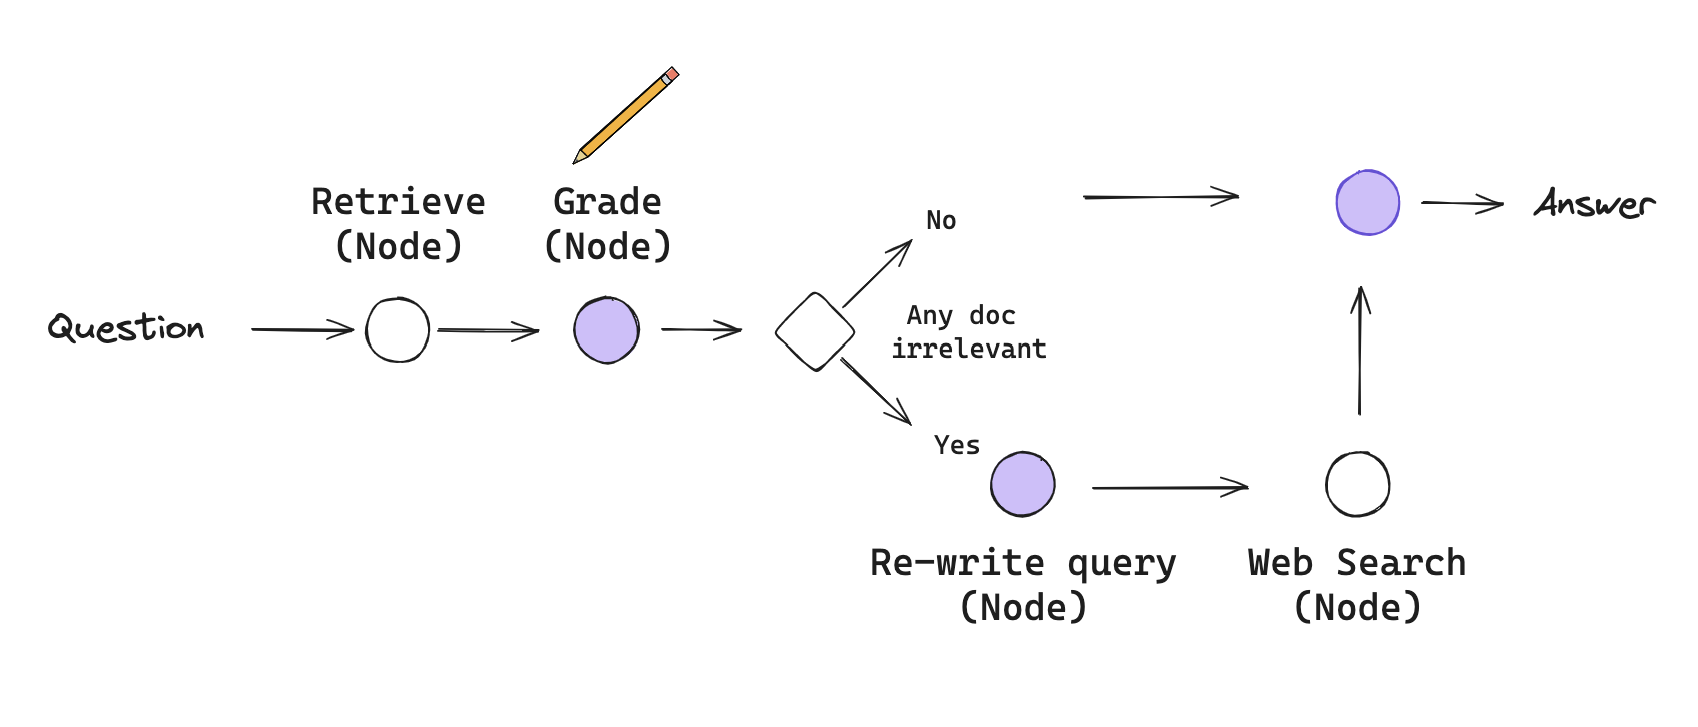![image.png](attachment:image.png)

## Setup

First, let's download our required packages and set our API keys


![image.png](attachment:image.png)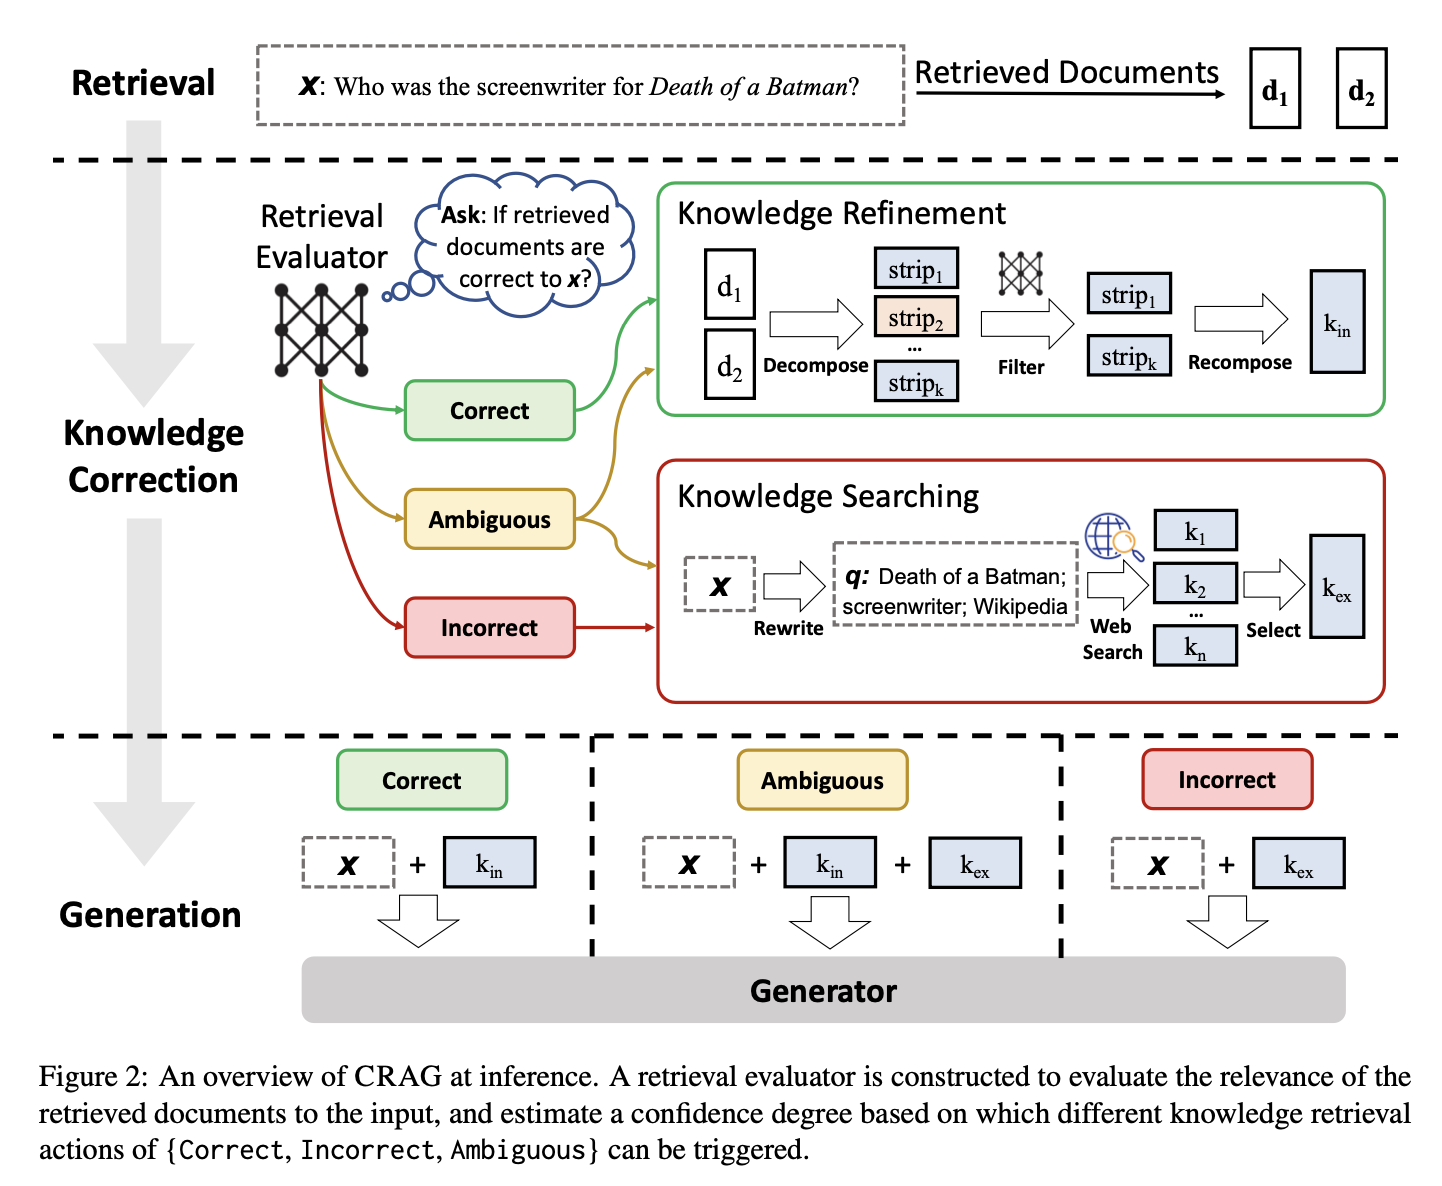

In [1]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip install -U duckduckgo_search==5.3.1b1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: duckduckgo_search
    Found existing installation: duckduckgo_search 6.2.12
    Uninstalling duckduckgo_search-6.2.12:
      Successfully uninstalled duckduckgo_search-6.2.12


In [3]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = 'true'

os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com'

os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')

os.environ["GOOGLE_API_KEY"] = os.getenv('GEMINI_API_KEY')

os.environ['USER_AGENT'] = 'myagent'

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=os.getenv("GEMINI_API_KEY")),
)
retriever = vectorstore.as_retriever()

## State

We will define a graph

Our state will be a dict.

We can access this from any graph node as state["keys"]

In [5]:
from typing_extensions import  Dict, TypedDict

from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
  """
  Represents the state of an agent in the conversation.

  Attributes:
    keys: A dictionary where each key is a string and the value is expected to be a list or another str
    that supports addition with `operator.add`. This could be used, for instance, to accumulate a
    or other pieces of data throughout the graph.
  """

  keys: Dict[str, any]

## Nodes and Edges

Each node will simply modify the `state`

Each edge will choose which node to call next.

It will follow the graph diagram shown above.

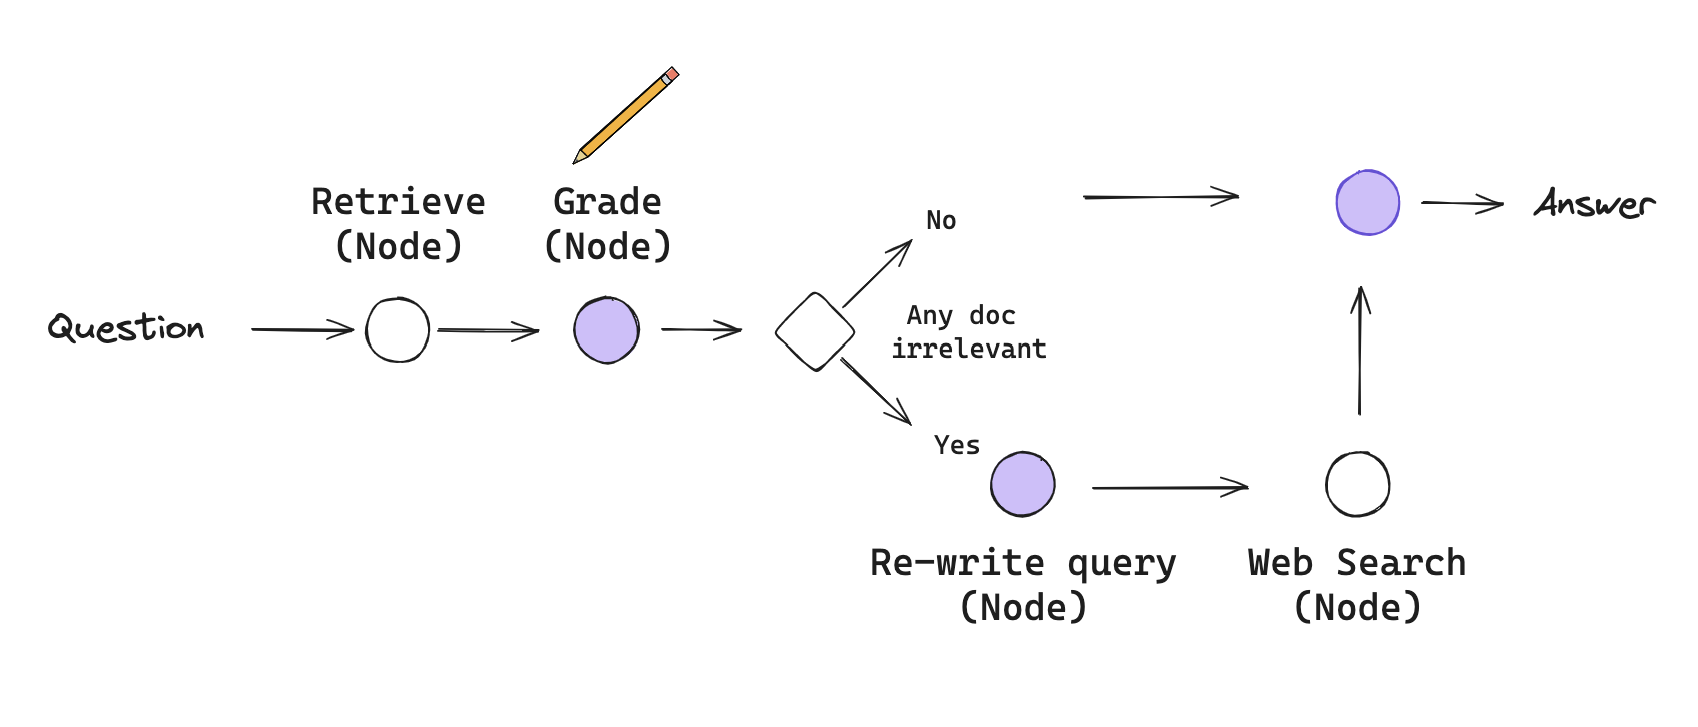

In [21]:
import json
import operator
from typing import  Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser, PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import TavilySearchResults
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_google_genai import GoogleGenerativeAI, GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolInvocation

### Nodes ###

def retrieve(state):
  """
  Retrieve documents

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New keys added to state, docments, that contain documents

  """
  print("----RETRIEVER----")
  state_dict = state["keys"]
  question = state_dict["question"]
  documents = retriever.get_relevant_documents(question)
  return {"keys": {"documents": documents, "question": question}}

def generate(state):
  """
  Genrate answer

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New keys added to state, docments, that contain documents

  """
  print("----GENERATE----")
  state_dict = state["keys"]
  question = state_dict["question"]
  documents = state_dict["documents"]

  # Prompt
  prompt = hub.pull("rlm/rag-prompt")

  # LLM
  llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=os.getenv("GEMINI_API_KEY"), temperature=0, streaming=True)

  # Post-processing
  def format_docs(docs):
    return "\n\n".join(docs.page_content for doc in docs)

  # Chain
  rag_chain = prompt | llm | StrOutputParser()

  # Run
  generation = rag_chain.invoke({"context": documents, "question": question})
  return {
      "keys": {
          "documents": documents,
          "question": question,
          "generation": generation
      }
  }


def grade_documents(state):
  """
  Determines whether the retrieved documents are relevant to the question

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New keys added to state, docments, that contain documents

  """
  print("----Check Relevance----")
  state_dict = state["keys"]
  question = state_dict["question"]
  documents = state_dict["documents"]

  # Data model
  class grade(BaseModel):
    """ Binary score for relevance check """
    binary_score: str = Field(
        description= "Relevance score 'yes' or 'no'"
    )

  # LLM
  model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=os.getenv("GEMINI_API_KEY"), temperature=0, streaming=True)

  # Tool
  grade_tool_oai = convert_to_openai_tool(grade)

  # LLM with tool and enforce invocation
  # llm_with_tool = model.bind(
  #     tools = [convert_to_openai_tool(grade_tool_oai)],
  #     tool_choice= {
  #         "type": "function",
  #         "function": {
  #             "name": "grade"
  #           }
  #         }
  # )
  # llm_with_tool = model.bind_tools([convert_to_openai_tool(grade_tool_oai)])
  llm_with_tool = model.bind_tools([grade])

  # Parser
  parser_tool = PydanticToolsParser(tools=[grade])

  # Prompt
  prompt = PromptTemplate(
      template="""You are a grader assessing relevance of a retrieved document to a user quesion. \n
      Here is the retrieved document: \n\n {context} \n\n
      Here is the user question: {question}  \n
      If the document contains keyword(s) or semantic meaning  related to the user question, grade it as relevant. \n
      Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
      input_variables=["context", "question"]
  )

  # Chain
  chain = prompt | llm_with_tool | parser_tool

  # Score
  filtered_docs = []
  search = "No" # Default do not opt for web search to supplement retrieval
  for d in documents:
    score = chain.invoke({"question": question, "context": d.page_content})
    grade = score[0].binary_score
    if grade == "yes":
      print("----GRADE: DOCUMENT RELEVANT----")
      filtered_docs.append(d)
    else:
      print("----GRADE: DOCUMENT NOT RELEVANT---")
      search = "Yes" # Perform web search
      continue

  return {
      "keys": {
          "documents": filtered_docs,
          "question": question,
          "run_web_search": search,
      }
  }

def transform_query(state):
  """
    Transform the query to produce a better question.

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New keys added to state, docments, that contain documents

  """
  print("----TRANSFORM QUERY----")
  state_dict = state["keys"]
  question = state_dict["question"]
  documents = state_dict["documents"]

  # Create a prompt template with format instructions and the query
  prompt = PromptTemplate(
      template= """ You are generating questions that will optimize for retrieval. \n
      Look at the input and try to reason about the underlying semantic intent / meaning . \n
      Write concise responses without unnecessary filler phrases or affirmations. \n
      Omit introductory phrases, elaborations, or commentary. \n
      Here is the initial question:
      \n ----- \n
      {question}
      \n ----- \n
      Formulate an improved question: """,
      input_variables=["question"]
  )

  # Grader
  model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=os.getenv("GEMINI_API_KEY"), temperature=0, streaming=True)

  # Prompt
  chain = prompt | model | StrOutputParser()
  better_question = chain.invoke({"question": question})

  return {
      "keys": {
          "documents": documents,
          "question": better_question
      }
  }

def web_search(state):
  """
  Web search using Tavily

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New keys added to state, docments, that contain documents

  """
  print("----WEB SEARCH----")
  state_dict = state["keys"]
  question = state_dict["question"]
  documents = state_dict["documents"]

  tool = TavilySearchResults()
  # tool = TavilySearchAPIRetriever(k=1, verbose=True)
  docs = tool.invoke({"query": question})
  # docs = tool.invoke(question)
  print(docs)
  web_results = "\n".join([d["content"] for d in docs])
  print(web_results)
  web_results = Document(page_content=web_results)
  print(web_results)
  documents.append(web_results)

  return {
      "keys": {
          "documents": documents,
          "question": question
      }
  }

  ### Edges

def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question.

  Args:
    state (dict): The current state fo the agent, including all the keys

  Returns:
    dict: New key added to state, docments, that contain documents

  """
  print("----DECIDE TO GENERATE----")
  state_dict = state["keys"]
  question = state_dict["question"]
  filtered_documents = state_dict["documents"]
  search = state_dict["run_web_search"]

  if search == "Yes":
    # All documents have been filtered check_relevance
    # We will re-generate a new query
    print("----DECISION: TRANSFORM QUERY and RUN WEB SEARCH----")
    return "transform_query"

  else:
    # We have relevant documents, so generate answer
    print("----DECISION: GENERATE----")
    return "generate"

In [22]:
import pprint
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade_documents
workflow.add_node("generate", generate) # generate
workflow.add_node("transform_query", transform_query) # transform_query
workflow.add_node("web_search", web_search) # web_search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [23]:
# Run
inputs = {
    "keys": {
        "question": "What is the approach taken in the Alpha podium paper?"
    }
  }

for output in app.stream(inputs):
  for key, value in output.items():
    pprint.pprint(f"Output from node '{key}'s")
    pprint.pprint("----")
    pprint.pprint(value["keys"], indent=2, width=80, depth=None)
  pprint.pprint("\n----\n")

----RETRIEVER----
"Output from node 'retrieve's"
'----'
{ 'documents': [ Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log"}, page_content='Reinforcement learning: Because the sampling steps are non-differentiable, a standard RL fine-tuning is needed to maximize the reward $\\mathbb{E}_{\\mathbf{x} \\sim p_\\text{red}(.)} [r(\\mathbf{x}, \\m